### This notebook is for the cryotempo eolis point data processing.


In [1]:
import h5py
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from utils.transform_time import second_to_dyr


In [2]:
path_hma_vec = 'data/boundary/hma_bolch2019.gpkg'
path_setp_vec = 'data/boundary/setp_zhao2022.gpkg'
path_cryotempo_readout = 'data/cryotempo-points/2021/data-readout/CS_OFFL_THEM_POINT_CENTRASIA_2021_12_+92388573_+30446348_V002_readout_subs.h5'
path_cryotempo_tile = 'data/cryotempo-points/2021/data-tiles/tile_30_95.h5'


In [3]:
!h5ls $path_cryotempo_readout
# !h5ls $path_cryotempo_tile


elevation                Dataset {358}
inputfileid              Dataset {358}
isSwath                  Dataset {358}
lat                      Dataset {358}
lon                      Dataset {358}
time                     Dataset {358}
uncertainty              Dataset {358}


In [4]:
cryo_readout = h5py.File(path_cryotempo_readout,'r')
cryo_tile = h5py.File(path_cryotempo_tile,'r')


In [5]:
# Dataframe meta data that describes results of query
print('Number of points =', len(cryo_tile['lon'][:]))


Number of points = 546


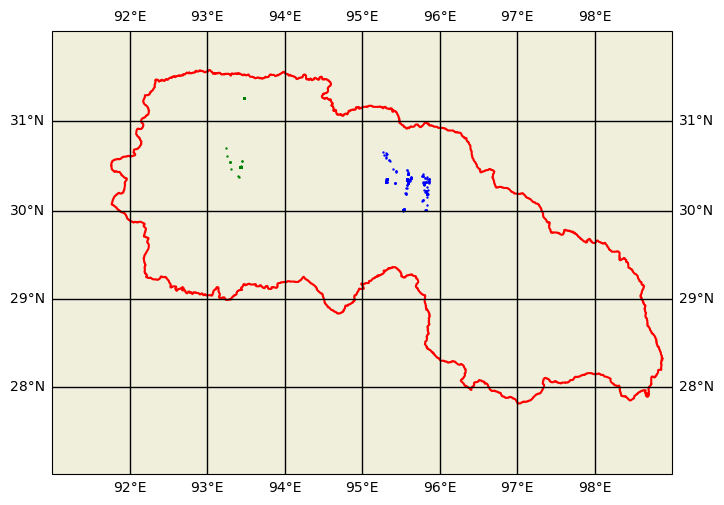

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mercator())
ax.set_extent([91, 99, 27.0, 32.0])
ax.add_feature(cfeature.LAND); 
ax.gridlines(draw_labels=True, linewidth=1, alpha=1, zorder=1, color='black')
## 1. setp boundary
shp_fea = cfeature.ShapelyFeature(Reader(path_setp_vec).geometries(), \
                      crs=ccrs.PlateCarree(), edgecolor='red', linewidth=1.5, facecolor='none')
ax.add_feature(shp_fea, zorder=0)

# 2.1. cryotempo points readout file
ax.scatter(x=cryo_readout['lon'][:], y=cryo_readout['lat'][:], c='green', s=0.5, \
                                                  transform=ccrs.PlateCarree(), zorder=0)
# 2.2. cryotempo points tile-based data
ax.scatter(x=cryo_tile['lon'][:], y=cryo_tile['lat'][:], c='blue', s=0.5, transform=ccrs.PlateCarree(), zorder=0)

